# Analyzing the Impact of Skycrapers on Climate Change

In [171]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://v1019.com/wp-content/uploads/sites/51/2018/01/Charlotte-Skyline.jpg", width=1024, height=478)

## Description
Project Description:<br>
<ul>
<li>The project focuses on analyzing the effect of infrastructure modifications from tall building units/skyscrapers on climate change.</li>
<li>The project includes a study of the energy usage by the building. Counterfactual models are required to measure the energy consumption done depending on four energy types. The consumption is based on historic usage rates and observed weather.</li>
<li>It can be then predicted how far will it affect and result in climate change in later years. A goal is to develop a predictive model for climage change based on energy consumption from skyscrapers.</li>
<li>The project has a data of over one thousand building's hourly meter reading for three years.</li>
</ul>

Team Members:<br>
<ul>
    <li>Ravina Gaikawad</li>
    <li>Sahithi Priya Gutta</li>
    <li>Uma Sai Madhuri Jetty</li>
    <li>Kevin Thomas</li>
</ul>

## Installing Dependancies, Importing Libraries

In [172]:
! pip install windrose

In [173]:
! pip install lightgbm

In [0]:
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
from datetime import datetime
import missingno as msno 
import seaborn as sns
from windrose import WindroseAxes

## Importing Data

This notebook was developed using Google's online IPython application: Colaboratory.<br>
The notebook can be run using Jupyter Notebooks as well.

### Google Colab Implementation

Run the following cells if the notebook is being run on Google Colab

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the following path to where the data is located.

In [0]:
PATH="/content/drive/My Drive/KDD Project/Data"

### Jupyter Notebook Implementation

Run the following cell if the notebook is being run on local machine. Data should be placed in a folder called data in the same directory as the IPython file.

In [0]:
PATH="./Data"

In [0]:
train_data = pd.read_csv(PATH+"/train.csv")

In [0]:
meta_data = pd.read_csv(PATH+"/building_metadata.csv")

In [0]:
weather_train_data = pd.read_csv(PATH+"/weather_train.csv")

## Preparing and Visualising the Data

### Train Data
This table consists energy usage of buildings.

<ul>
  <li>building_id - Foreign key for the building metadata.
  <li>meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
  <li>timestamp - When the measurement was taken
  <li>meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.
</ul>

In [183]:
train_data.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [184]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [185]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


Visualizing Meter Distribution

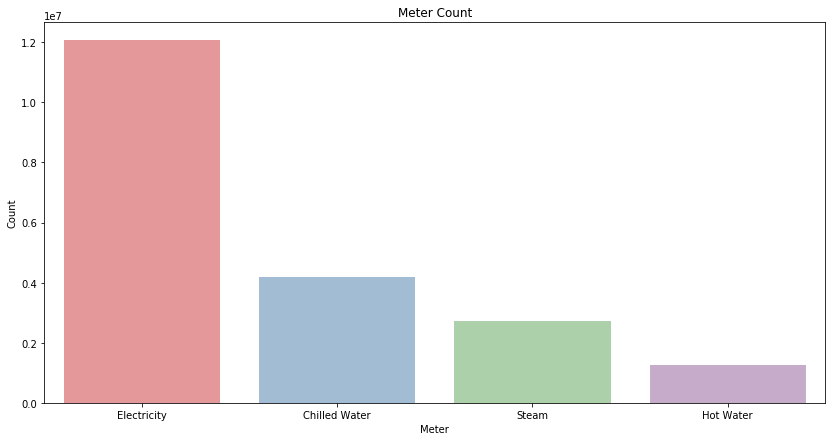

In [186]:
plt.rcParams['figure.figsize'] = (14, 7)
sns.countplot(data = train_data, x ='meter', palette = 'Set1', alpha = 0.5)
plt.title("Meter Count")
plt.xlabel("Meter")
plt.ylabel("Count")
plt.xticks(ticks = [0, 1, 2, 3], labels = ["Electricity", "Chilled Water", "Steam", "Hot Water"])
plt.show()

### Building Meta-Data
<ul>
  <li>site_id - Foreign key for the weather files.
  <li>building_id - Foreign key for training.csv
  <li>primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
  <li>square_feet - Gross floor area of the building
  <li>year_built - Year building was opened
  <li>floor_count - Number of floors of the building
</ul>

In [187]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [188]:
meta_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


Visualizing primary use of buildings

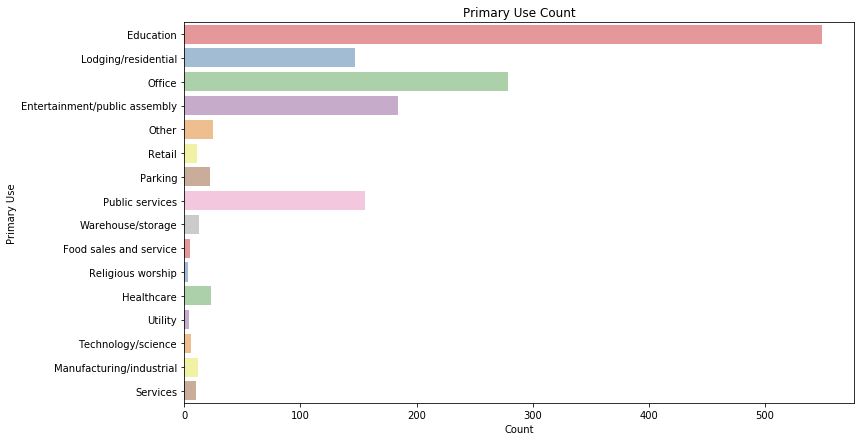

In [189]:
plt.figure(figsize=(12, 7))
sns.countplot(data = meta_data, y ='primary_use', palette = 'Set1', alpha = 0.5)
# meta_data.primary_use.value_counts().plot(kind='barh', color='#0504aa',alpha=0.7, width = 0.5)
plt.title("Primary Use Count")
plt.xlabel("Count")
plt.ylabel("Primary Use")
plt.show()

Due to the large amount of missing values in the "year_built" and "floor_count" columns in the building metadata table, we dropped these two columns. The use of square_feet enables us to ignore floor_count as they both represent the size of a building. While the age of a building will impact its power consumption, the sheer number of missing values in the dataset coupled with the inability to impute the values has prompted the dropping of this column.

In [0]:
meta_data = meta_data.drop(['year_built', 'floor_count'], axis=1)

In [191]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 4 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.4+ KB


In [192]:
meta_data.describe()

,site_id,building_id,square_feet
count,1449.000000,1449.000000,1449.000000
mean,6.952381,724.000000,92111.776398
std,5.003432,418.434583,110769.950997
min,0.000000,0.000000,283.000000
25%,3.000000,362.000000,23012.000000
50%,5.000000,724.000000,57673.000000
75%,13.000000,1086.000000,115676.000000
max,15.000000,1448.000000,875000.000000


### Weather Data
<ul>
<li>site_id
<li>air_temperature - Degrees Celsius
<li>cloud_coverage - Portion of the sky covered in clouds, in oktas
<li>dew_temperature - Degrees Celsius
<li>precip_depth_1_hr - Millimeters
<li>sea_level_pressure - Millibar/hectopascals
<li>wind_direction - Compass direction (0-360)
<li>wind_speed - Meters per second

In [193]:
weather_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [194]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [195]:
weather_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Visualizing wind speed and direction using WindRose

<Figure size 576x576 with 0 Axes>

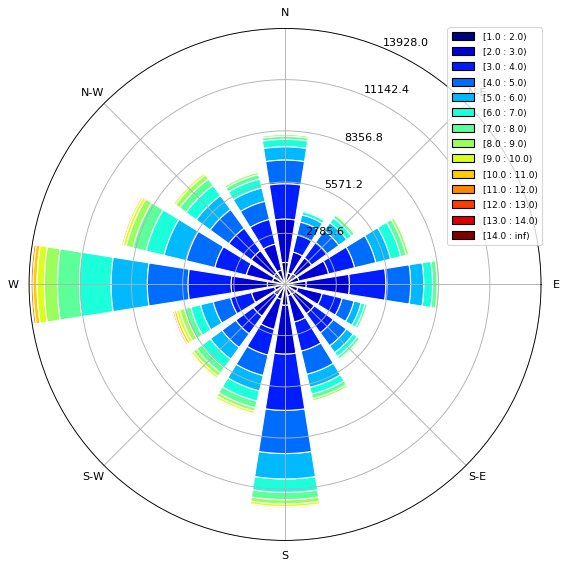

In [196]:
plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
bins_range = np.arange(1,15,1)
ax.bar(weather_train_data.wind_direction, weather_train_data.wind_speed, opening=0.8, edgecolor='white', bins=bins_range)
ax.set_legend(loc=1)
plt.show()

We drop some variables that are irrelevant and have large amounts of missing data.

In [0]:
weather_train_data = weather_train_data.drop(['precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 'wind_direction'], axis=1)

In [0]:
weather_train_data.dropna(axis=0, inplace=True)

In [199]:
weather_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139393 entries, 0 to 139772
Data columns (total 5 columns):
site_id            139393 non-null int64
timestamp          139393 non-null object
air_temperature    139393 non-null float64
dew_temperature    139393 non-null float64
wind_speed         139393 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.4+ MB


In [200]:
weather_train_data.describe()

,site_id,air_temperature,dew_temperature,wind_speed
count,139393.000000,139393.000000,139393.000000,139393.000000
mean,7.473926,14.407688,7.347791,3.560702
std,4.607432,10.622384,9.790117,2.336138
min,0.000000,-28.900000,-35.000000,0.000000
25%,3.000000,7.200000,0.600000,2.100000
50%,7.000000,15.000000,8.300000,3.100000
75%,11.000000,22.200000,14.400000,5.000000
max,15.000000,47.200000,26.100000,19.000000


Changing the timestamp variable from object to timestamp data type

In [0]:
weather_train_data['timestamp'] = pd.to_datetime(weather_train_data['timestamp'])

Visualizing air temperature over time

In [202]:
import plotly.express as px
fig = px.line(weather_train_data[weather_train_data.site_id==1], x='timestamp', y='air_temperature')
fig.show()

Splitting the timestamp variable in the train dataset into two columns: date and time. Both columns are of tiype datetime.

In [0]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

In [0]:
# train_data['date'] = train_data['timestamp'].dt.date
train_data['date'] = train_data['timestamp'].dt.normalize()

In [0]:
train_data['time'] = train_data['timestamp'].dt.time
train_data['hour'] = pd.to_datetime(train_data['time'], format='%H:%M:%S').dt.hour

In [0]:
train_data = train_data.drop(['time'], axis = 1)

In [207]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 6 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
date             datetime64[ns]
hour             int64
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 925.4 MB


In [208]:
train_data.describe()

,building_id,meter,meter_reading,hour
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,1.150232e+01
std,4.269133e+02,9.309921e-01,1.532356e+05,6.922017e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,6.000000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,1.200000e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.800000e+01
max,1.448000e+03,3.000000e+00,2.190470e+07,2.300000e+01


Splitting the timestamp variable in the weather dataset into two columns: date and time. Both columns are of type datetime.

In [0]:
weather_train_data['timestamp'] = pd.to_datetime(weather_train_data['timestamp'])

In [0]:
weather_train_data['date'] = weather_train_data['timestamp'].dt.normalize()

In [0]:
weather_train_data['time'] = weather_train_data['timestamp'].dt.time
weather_train_data['hour'] = pd.to_datetime(weather_train_data['time'], format='%H:%M:%S').dt.hour

In [0]:
weather_train_data = weather_train_data.drop(['time'], axis = 1)

In [213]:
weather_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139393 entries, 0 to 139772
Data columns (total 7 columns):
site_id            139393 non-null int64
timestamp          139393 non-null datetime64[ns]
air_temperature    139393 non-null float64
dew_temperature    139393 non-null float64
wind_speed         139393 non-null float64
date               139393 non-null datetime64[ns]
hour               139393 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 8.5 MB


In [214]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 4 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.4+ KB


Combining all the tables into one big dataset

Merging Building metadata and train dataset on the basis on building_id.

In [0]:
temp_merge = pd.merge(left=train_data, right=meta_data, left_on='building_id', right_on='building_id', how='outer')

In [216]:
temp_merge.head()

,building_id,meter,timestamp,meter_reading,date,hour,site_id,primary_use,square_feet
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,0,0,Education,7432
1,0,0,2016-01-01 01:00:00,0.0,2016-01-01,1,0,Education,7432
2,0,0,2016-01-01 02:00:00,0.0,2016-01-01,2,0,Education,7432
3,0,0,2016-01-01 03:00:00,0.0,2016-01-01,3,0,Education,7432
4,0,0,2016-01-01 04:00:00,0.0,2016-01-01,4,0,Education,7432


Merging weather data and the combined table from the last merge step into the final table. This is done on the basis of site_id, date and hour.

In [0]:
train = pd.merge(left=temp_merge, right=weather_train_data, left_on=['site_id', 'date', 'hour'], right_on=['site_id', 'date', 'hour'], how='outer')

Deleting the unnecessary variables to save memory.

In [0]:
# del temp_merge, train_data, meta_data, weather_train_data

In [219]:
train.head()

,building_id,meter,timestamp_x,meter_reading,date,hour,site_id,primary_use,square_feet,timestamp_y,air_temperature,dew_temperature,wind_speed
0,0.0,0.0,2016-01-01,0.0,2016-01-01,0,0,Education,7432.0,2016-01-01,25.0,20.0,0.0
1,1.0,0.0,2016-01-01,0.0,2016-01-01,0,0,Education,2720.0,2016-01-01,25.0,20.0,0.0
2,2.0,0.0,2016-01-01,0.0,2016-01-01,0,0,Education,5376.0,2016-01-01,25.0,20.0,0.0
3,3.0,0.0,2016-01-01,0.0,2016-01-01,0,0,Education,23685.0,2016-01-01,25.0,20.0,0.0
4,4.0,0.0,2016-01-01,0.0,2016-01-01,0,0,Education,116607.0,2016-01-01,25.0,20.0,0.0


In [220]:
train.isna().sum()

building_id           135
meter                 135
timestamp_x           135
meter_reading         135
date                    0
hour                    0
site_id                 0
primary_use           135
square_feet           135
timestamp_y        148395
air_temperature    148395
dew_temperature    148395
wind_speed         148395
dtype: int64

In [0]:
train = train.dropna(axis=0, subset=['building_id'])

In [222]:
train.isna().sum()

building_id             0
meter                   0
timestamp_x             0
meter_reading           0
date                    0
hour                    0
site_id                 0
primary_use             0
square_feet             0
timestamp_y        148395
air_temperature    148395
dew_temperature    148395
wind_speed         148395
dtype: int64

Dropping some column artifacts.

In [0]:
train = train.drop(['timestamp_x', 'timestamp_y'], axis=1)

In [0]:
train = train.dropna(axis=0, subset=['air_temperature','dew_temperature'])

In [225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20067705 entries, 0 to 20216099
Data columns (total 11 columns):
building_id        float64
meter              float64
meter_reading      float64
date               datetime64[ns]
hour               int64
site_id            int64
primary_use        object
square_feet        float64
air_temperature    float64
dew_temperature    float64
wind_speed         float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 1.8+ GB


In [0]:
data = np.random.randint(low=0, high=20067705, size=20067705//2)
train.drop(train.index[data],0,inplace=True)


In [227]:
train.reset_index(drop=True)

,building_id,meter,meter_reading,date,hour,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed
0,0.0,0.0,0.0000,2016-01-01,0,0,Education,7432.0,25.0,20.0,0.0
1,1.0,0.0,0.0000,2016-01-01,0,0,Education,2720.0,25.0,20.0,0.0
2,2.0,0.0,0.0000,2016-01-01,0,0,Education,5376.0,25.0,20.0,0.0
3,4.0,0.0,0.0000,2016-01-01,0,0,Education,116607.0,25.0,20.0,0.0
4,5.0,0.0,0.0000,2016-01-01,0,0,Education,8000.0,25.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12173157,1400.0,1.0,4.6566,2016-03-24,11,15,Lodging/residential,21168.0,1.7,1.1,0.0
12173158,1400.0,1.0,25.0848,2016-03-24,13,15,Lodging/residential,21168.0,2.8,2.2,1.5
12173159,1400.0,1.0,32.3439,2016-03-24,14,15,Lodging/residential,21168.0,5.6,4.4,2.1
12173160,1400.0,1.0,24.2214,2016-03-24,15,15,Lodging/residential,21168.0,11.1,4.4,5.1


Removing outliers using interquartile range

In [0]:
Q1 = train['meter_reading'].quantile(0.25)
Q3 = train['meter_reading'].quantile(0.75)
IQR = Q3 - Q1
train_final = train[train['meter_reading'] > (Q1 - 1.5 * IQR)][:]
train_final = train_final[train_final['meter_reading'] < (Q3 + 1.5 * IQR)][:]

In [229]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682582 entries, 0 to 20216099
Data columns (total 11 columns):
building_id        float64
meter              float64
meter_reading      float64
date               datetime64[ns]
hour               int64
site_id            int64
primary_use        object
square_feet        float64
air_temperature    float64
dew_temperature    float64
wind_speed         float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 978.0+ MB


In [230]:
train_final.isna().sum()

building_id        0
meter              0
meter_reading      0
date               0
hour               0
site_id            0
primary_use        0
square_feet        0
air_temperature    0
dew_temperature    0
wind_speed         0
dtype: int64

In [231]:
train_final.describe()

,building_id,meter,meter_reading,hour,site_id,square_feet,air_temperature,dew_temperature,wind_speed
count,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07,1.068258e+07
mean,7.756834e+02,5.803126e-01,1.176209e+02,1.145972e+01,7.687434e+00,9.115281e+04,1.620857e+01,7.856638e+00,3.376340e+00
std,4.249695e+02,9.070368e-01,1.453428e+02,6.945406e+00,5.057196e+00,9.516882e+04,1.067366e+01,9.941448e+00,2.269172e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,-2.890000e+01,-3.500000e+01,0.000000e+00
25%,3.620000e+02,0.000000e+00,1.382780e+01,5.000000e+00,3.000000e+00,2.799500e+04,8.900000e+00,6.000000e-01,2.100000e+00
50%,8.640000e+02,0.000000e+00,5.805000e+01,1.100000e+01,8.000000e+00,6.456000e+04,1.670000e+01,8.900000e+00,3.100000e+00
75%,1.153000e+03,1.000000e+00,1.652530e+02,1.700000e+01,1.300000e+01,1.189660e+05,2.390000e+01,1.560000e+01,4.600000e+00
max,1.448000e+03,3.000000e+00,6.414920e+02,2.300000e+01,1.500000e+01,8.750000e+05,4.720000e+01,2.610000e+01,1.900000e+01


We can see that the above dataframe is very large in size, thus occupying a good portion of a system's memory. To counter this, we downgrade the datatypes into their lowest memory variants. This reduces the size greatly.

In [0]:
train_final.primary_use = train.primary_use.astype("category")

In [233]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682582 entries, 0 to 20216099
Data columns (total 11 columns):
building_id        float64
meter              float64
meter_reading      float64
date               datetime64[ns]
hour               int64
site_id            int64
primary_use        category
square_feet        float64
air_temperature    float64
dew_temperature    float64
wind_speed         float64
dtypes: category(1), datetime64[ns](1), float64(7), int64(2)
memory usage: 906.7 MB


To save compute time, we store the dataset in a pickle file

In [0]:
train_final.to_pickle("train_data.pkl")

In [0]:
del train_final

The data can be read from the pickle file using the following command.

In [0]:
train = pd.read_pickle("train_data.pkl")

Correlation matrix for our dataset

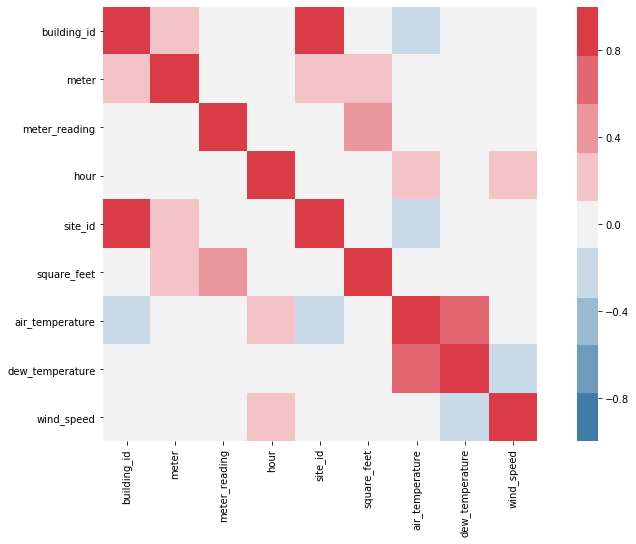

In [240]:
plt.rcParams['figure.figsize'] = (14,8)
sns.heatmap(train.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(240, 10, n=9))
plt.show()

## Data Preparation

### Encoding Categorical Variables
##### Primary Use:
We use Label Encoding to convert Primary use into numerical values.

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [242]:
train['primary_use']

0                     Education
1                     Education
2                     Education
4                     Education
5                     Education
                   ...         
20216094    Lodging/residential
20216096    Lodging/residential
20216097    Lodging/residential
20216098    Lodging/residential
20216099    Lodging/residential
Name: primary_use, Length: 10682582, dtype: category
Categories (16, object): [Education, Entertainment/public assembly, Food sales and service,
                          Healthcare, ..., Services, Technology/science, Utility,
                          Warehouse/storage]

In [0]:
train['primary_use'] = encoder.fit_transform(train['primary_use'])

##### Meter
The meter variable is converted into four separate binary columns using One Hot Encoding.

In [0]:
dummy = pd.get_dummies(train['meter'])

In [0]:
train = pd.concat([train, dummy], axis=1)

In [246]:
train.head()

,building_id,meter,meter_reading,date,hour,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,0.0,1.0,2.0,3.0
0,0.0,0.0,0.0,2016-01-01,0,0,0,7432.0,25.0,20.0,0.0,1,0,0,0
1,1.0,0.0,0.0,2016-01-01,0,0,0,2720.0,25.0,20.0,0.0,1,0,0,0
2,2.0,0.0,0.0,2016-01-01,0,0,0,5376.0,25.0,20.0,0.0,1,0,0,0
4,4.0,0.0,0.0,2016-01-01,0,0,0,116607.0,25.0,20.0,0.0,1,0,0,0
5,5.0,0.0,0.0,2016-01-01,0,0,0,8000.0,25.0,20.0,0.0,1,0,0,0


### Scaling
We use standard scaler to scale square feet. We do this because it has the most variance in the dataset.

In [0]:
train['square_feet'] = np.log1p(train['square_feet'])

In [248]:
train.head()

,building_id,meter,meter_reading,date,hour,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,0.0,1.0,2.0,3.0
0,0.0,0.0,0.0,2016-01-01,0,0,0,8.913685,25.0,20.0,0.0,1,0,0,0
1,1.0,0.0,0.0,2016-01-01,0,0,0,7.908755,25.0,20.0,0.0,1,0,0,0
2,2.0,0.0,0.0,2016-01-01,0,0,0,8.589886,25.0,20.0,0.0,1,0,0,0
4,4.0,0.0,0.0,2016-01-01,0,0,0,11.666573,25.0,20.0,0.0,1,0,0,0
5,5.0,0.0,0.0,2016-01-01,0,0,0,8.987322,25.0,20.0,0.0,1,0,0,0


### Feature Reduction

We select the important features from our data and split it into two Dataframes with independant variables and dependant variables.

In [0]:
X = train.drop(columns="meter_reading")
Y = train['meter_reading']

In [0]:
X.drop(columns=['building_id', 'site_id', 'date', 'meter'], axis=1, inplace=True)

Splitting the data into training and testing set. The test set percentage is set to 20%

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [0]:
# x_train, x_test, y_train, y_test = train_test_split(temp, Y, test_size = 0.20, random_state = 0)

In [253]:
x_train.head()

,hour,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,0.0,1.0,2.0,3.0
5567959,9,0,11.150534,24.4,23.3,3.1,1,0,0,0
4553853,18,0,11.000448,17.2,1.1,5.7,1,0,0,0
4266592,10,0,11.100451,2.8,-3.9,4.6,1,0,0,0
14597762,8,0,9.560011,19.4,15.6,0.0,0,1,0,0
15297494,19,6,10.957712,21.1,11.7,3.6,1,0,0,0


In [254]:
y_train.head()

5567959      93.690
4553853      75.470
4266592     124.220
14597762      0.000
15297494     97.667
Name: meter_reading, dtype: float64

## Modelling

LightGBM<br>
Light GBM is a gradient boosting framework that uses tree based learning algorithm. How it differs from other tree based algorithm?
Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

Reference: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

### Training

In [0]:
import lightgbm as lgb

In [0]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test)

In [0]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': {'rmse'},
          'learning_rate': 0.8,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq' : 5
          }

In [258]:
  gbm_regress = lgb.train(params,
              lgb_train,
              num_boost_round=4000,
              valid_sets=(lgb_train, lgb_test),
            early_stopping_rounds=20,
            verbose_eval = 20)

Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 106.47	valid_1's rmse: 106.528
[40]	training's rmse: 99.3353	valid_1's rmse: 99.4038
[60]	training's rmse: 95.6981	valid_1's rmse: 95.8043
[80]	training's rmse: 92.6527	valid_1's rmse: 92.7721
[100]	training's rmse: 90.2338	valid_1's rmse: 90.3859
[120]	training's rmse: 88.0032	valid_1's rmse: 88.193
[140]	training's rmse: 86.7461	valid_1's rmse: 86.9801
[160]	training's rmse: 85.5623	valid_1's rmse: 85.8154
[180]	training's rmse: 84.7424	valid_1's rmse: 84.9963
[200]	training's rmse: 83.8994	valid_1's rmse: 84.1948
[220]	training's rmse: 83.3142	valid_1's rmse: 83.6405
[240]	training's rmse: 82.8916	valid_1's rmse: 83.2482
[260]	training's rmse: 82.4007	valid_1's rmse: 82.775
[280]	training's rmse: 81.9287	valid_1's rmse: 82.3342
[300]	training's rmse: 81.4677	valid_1's rmse: 81.8977
[320]	training's rmse: 81.1472	valid_1's rmse: 81.6051
[340]	training's rmse: 80.755	valid_1's rmse: 81.2644
[360]	train

### Testing

In [0]:
y_pred=gbm_regress.predict(x_test)

In [0]:
from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(y_test, y_pred))

In [261]:
print("The Test RMSE score for our model:", score)

The Test RMSE score for our model: 73.15604209334575
